# Trick for numeric data

### factors to consider
- size of values
    - only positive values? or also negative values?
    - are the values able to be expressed in bins?
- scale
    - smoothing functions/models such as k-NN, k-means, RBF are scale dependent
    - logical functions/models such as tree-based models, gradient boosting machine, random forest are less dependent to scale of data
- distributions (데이터의 분포)
- usage of polynomial features (상호작용 피처)

In [2]:
import pandas as pd
import json

## 1. Processing Counts

### 1.1. Binarize

In [6]:
data = open('../data/yelp_academic_dataset_business.json')
df = pd.DataFrame([json.loads(x) for x in data.readlines()])
data.close()

In [11]:
df.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None


In [12]:
df['stars_to_binary'] = df['stars'].apply(lambda x : 1 if x > 3 else 0)

In [15]:
df[['stars', 'stars_to_binary']].head(10)

,stars,stars_to_binary
0,5.0,1
1,3.0,0
2,3.5,1
3,4.0,1
4,4.5,1
5,2.0,0
6,2.5,0
7,3.5,1
8,3.0,0
9,1.5,0


### 1.2. Quantization (count -> bin)
- fixed-length binning(고정 폭 비닝)
    - 상수적 폭 (1-10, 11-20)
    - 지수적 폭 (10, 100, 1000)
    - 로그 폭 (8, 4, 2, 1)

In [22]:
# fixed-binning by size of 10
# ex. 0-99 사이의 숫자로만 구성된 경우 => %10 해서 0-9에 매핑
import numpy as np 
counts = np.random.randint(0, 100, 20)
np.floor_divide(counts, 10) 

array([8, 9, 1, 4, 6, 1, 3, 3, 9, 6, 5, 3, 1, 0, 7, 5, 5, 3, 2, 6])

In [24]:
# fixed-binning by log
# ex. 여러 자리수에 걸쳐 있는 카운트 배열 => 로그 함수에 매핑
counts = np.random.randint(100, 10000, 20)
np.floor(np.log10(counts))

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 3., 2., 3., 3., 3., 3., 3.,
       3., 3., 2.])

### 1.3. Quantile Binning (counts -> quantiles)
앞선 고정 폭 비닝은 사용하긴 쉽지만, 카운트 사이에 갭이 있다면 데이터가 비어 있는 빈(bin)이 많아진다. => 분포의 분위수를 이용하여 비닝 수행

In [31]:
counts_series = pd.Series(counts)
print('result of 25%, 50%, 75% : \n', counts_series.quantile([0.25, 0.5, 0.75]), sep = '')

result of 25%, 50%, 75% : 
0.25    1345.75
0.50    2555.50
0.75    5993.25
dtype: float64


In [32]:
print('result of 10%, 20%, 30%, ..., 90% : \n', 
        counts_series.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), sep = '')

result of 10%, 20%, 30%, ..., 90% : 
0.1     875.4
0.2    1169.6
0.3    1696.7
0.4    2039.4
0.5    2555.5
0.6    4010.8
0.7    5463.0
0.8    6603.0
0.9    7639.6
dtype: float64


In [33]:
# using qcut to map counts to quantile bins
pd.qcut(counts, 10, labels = False)

array([9, 2, 7, 9, 5, 6, 7, 6, 1, 0, 2, 1, 3, 8, 3, 5, 8, 4, 4, 0])

## 2. Log Transformation (a.k.a. Variance-Stabilizing Transformation)
Log transformation is a powerful tool in feature engineering, and it's frequently used in various data science and statistical contexts. Here are the reasons why log transformation can be beneficial:

- Transforming Skewed Data: Many algorithms (e.g., linear regression) assume that the data is normally distributed, or at least symmetrically distributed. If a feature is highly skewed, a log transformation can help in making the data more "normal". This can make certain algorithms perform better and predictions more accurate.
- Stabilizing Variance: In some scenarios, the variance of a dataset might increase with the level of the variable (heteroscedasticity). Log transformation can help stabilize the variance across levels.
- Easier Interpretability: In certain contexts, especially when dealing with growth rates or multiplicative changes, a log-transformed scale can be more intuitive. For instance, in finance, log returns are commonly used because they are additive across time.
- Reducing the Influence of Outliers: Log transformation can decrease the relative gaps between values, especially when values have a wide range. This can, in turn, reduce the undue influence of extreme values or outliers.
- Making Relationships More Linear: In cases where the relationship between the response and the predictor variables is inherently exponential or multiplicative, taking the log of one or both variables might make the relationship more linear, and thus more suitable for algorithms that assume linear relationships.
- Scaling Down Values: Some features might have values that are several orders of magnitude larger than others. Log transformation can scale these values down to a range that's more manageable for many algorithms.

However, while log transformation has its benefits, there are also considerations and limitations:
- Positive Values Only: You can only take the log of positive values. If your data contains zero or negative values, you'll need to apply an offset or use another transformation.
- Loss of Original Scale: Once you transform your data, it’s on a different scale. This can sometimes make interpretation less intuitive if you're not accustomed to thinking in logarithmic terms.
- Not Always the Best Transformation: Depending on the specific characteristics of your data and the problem at hand, other transformations (e.g., square root, inverse, Box-Cox) might be more appropriate.

In [36]:
from scipy import stats 

# data에 Yelp 비즈니스 리뷰 데이터를 담아준다.
# 거듭제곱 변환(Log, Box-Cox 변환)해주기 위한 라이브러리를 불러온다
# 이때 Box-Cox 변환은 입력 데이터가 양수라고 가정한다.

# log 변환
df['review_cnt_log'] = stats.boxcox(df['review_count'], lmbda = 0) 

# Box-Cox 변환
# 출력을 정규 분포에 가장 가깝게 만드는 람다 파라미터와, 변환의 결과를 반환한다 
df['review_cnt_boxcox'], boxcox_params = stats.boxcox(df['review_count'])

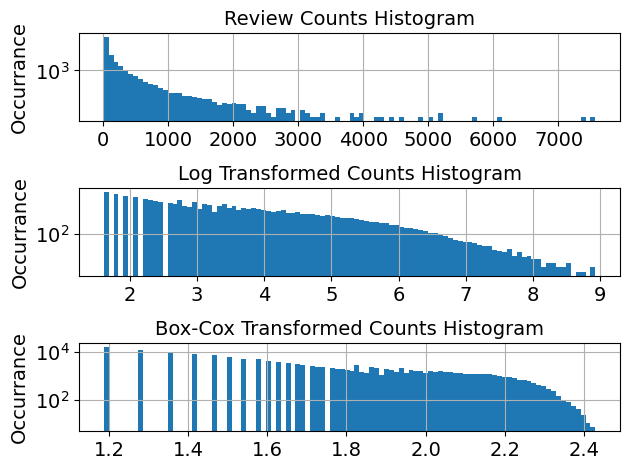

In [38]:
# 시각화
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# 원본 리뷰 카운트 히스토그램
df['review_count'].hist(ax = ax1, bins = 100)
ax1.set_yscale('log')
ax1.tick_params(labelsize = 14)
ax1.set_title('Review Counts Histogram', fontsize = 14)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrance', fontsize = 14)

# 로그 변환된 리뷰 카운트 히스토그램
df['review_cnt_log'].hist(ax = ax2, bins = 100)
ax2.set_yscale('log')
ax2.tick_params(labelsize = 14)
ax2.set_title('Log Transformed Counts Histogram', fontsize = 14)
ax2.set_xlabel('')
ax2.set_ylabel('Occurrance', fontsize = 14)

# Box-Cox 변환된 리뷰 카운트 히스토그램
df['review_cnt_boxcox'].hist(ax = ax3, bins = 100)
ax3.set_yscale('log')
ax3.tick_params(labelsize = 14)
ax3.set_title('Box-Cox Transformed Counts Histogram', fontsize = 14)
ax3.set_xlabel('')
ax3.set_ylabel('Occurrance', fontsize = 14)

plt.tight_layout()
plt.show()

# 3. Feature Scaling, Feature Normalization
- 피처 스케일에 민감한 모델은 스케일링 진행
- 일반적으로 각각의 피처에 대해서 개별적으로 수행함

In [39]:
# read Online News Popularity dataset
df = pd.read_csv('../data/OnlineNewsPopularity.csv', delimiter = ', ')
df.head()

/var/folders/5n/2hnyrkv51vbd56wdk0kttw980000gn/T/ipykernel_43921/3997919622.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../data/OnlineNewsPopularity.csv', delimiter = ', ')


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [46]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()

In [49]:
X = df[['n_tokens_content']]
df['X_min_max'] = min_max_scaler.fit_transform(X)
df['X_stand'] = standard_scaler.fit_transform(X)
df['X_l2'] = preprocessing.normalize(X, axis = 0)

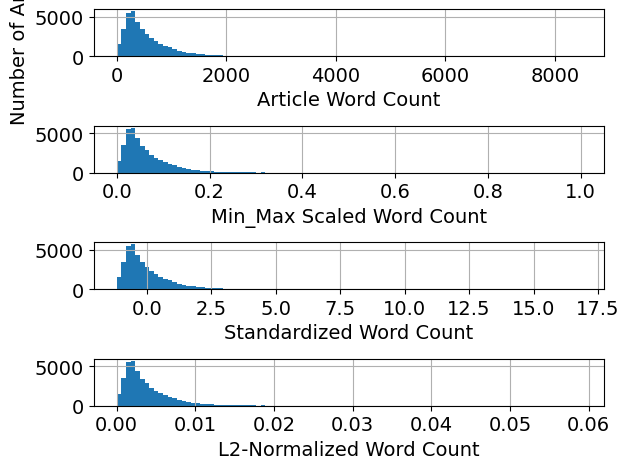

In [50]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

df['n_tokens_content'].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize = 14)
ax1.set_xlabel('Article Word Count', fontsize = 14)
ax1.set_ylabel('Number of Articles', fontsize = 14)

df['X_min_max'].hist(ax=ax2, bins=100)
ax2.tick_params(labelsize = 14)
ax2.set_xlabel('Min_Max Scaled Word Count', fontsize = 14)

df['X_stand'].hist(ax=ax3, bins=100)
ax3.tick_params(labelsize = 14)
ax3.set_xlabel('Standardized Word Count', fontsize = 14)

df['X_l2'].hist(ax=ax4, bins=100)
ax4.tick_params(labelsize = 14)
ax4.set_xlabel('L2-Normalized Word Count', fontsize = 14)
fig.tight_layout()

# 4. Polynomial Features
Combining more than 2 features
- 1. 단순 선형결합: y = w1x1 + w2x2 + .. + wnxn
- 2. 쌍 결합(pairwise): y = w1x1 + w2x2 + .. + wnxn + w11x1x1 + w12x1x2 + ... + w1nx1xn + wnnxnxn

In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing


In [13]:
df = pd.read_csv('../data/OnlineNewsPopularity.csv', delimiter = ', ')

# 파생 피처를 제외하고 콘텐츠 기반 피처만 개별 피처로 선택해서 모델에서 사용
features = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', \
            'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', \
            'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', \
            'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world'
        ]
X = df[features]
X2 = preprocessing.PolynomialFeatures(include_bias=False).fit_transform(X)
y = df[['shares']]

/var/folders/5n/2hnyrkv51vbd56wdk0kttw980000gn/T/ipykernel_57133/2361188668.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('../data/OnlineNewsPopularity.csv', delimiter = ', ')


In [14]:
# 두개의 피처 집합을 모두 train, test set으로 분할 
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X, X2, y, test_size = 0.3, random_state=42)

def evaluate_feature(X_train, X_test, y_train, y_test):
    model = LinearRegression().fit(X_train, y_train)
    r_score = model.score(X_test, y_test)
    return (model, r_score)

# 두 피처 집합에 대해서 모델 학습 시키고 점수 비교 
(m1, r1) = evaluate_feature(X1_train, X1_test, y_train, y_test)
(m2, r2) = evaluate_feature(X2_train, X2_test, y_train, y_test)
print('R-squared score with singleton features: %.5f'%r1)
print('R-squared source with pairwise features: %.10f'%r2)



R-squared score with singleton features: 0.00926
R-squared source with pairwise features: 0.0042263978


# 5. Feature Selection
- 모델 복잡성을 줄이기 위해 불필요한 피처 제거 
- 최종 목표는 모델 성능 저하 시키지 않으면서 빠른 계산을 하는 간결한 모델 만들기

#### (1) 필터링
- 하지만 모델을 고려하지 않은 단계에서 피처를 없앤 것이니, 모델에 적합한 피처를 무심코 제거하는 실수가 될 수 O
#### (2) 래퍼 메소드
- 피처의 하위집합 시험 가능. 하지만 비용이 높아진다
#### (3) 내장 메소드
- 모델 학습 과정의 일부로서 피처 선택 수행 (L1 norm 추가 등)
- 장점: 비용 적음
- 단점: 래퍼 메소드보다 약함